In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from zipfile import ZipFile
import skimage.io
from PIL import Image
import seaborn as sns
from sklearn.manifold import TSNE
import random

from mnist_generator import get_mnist_loaders
from mnistm_generator import get_mnistm_loaders
from DANN import *
from DA import *
from test import *
from train import *
from visualize import *
from util import *
#https://github.com/fungtion/DSN/blob/master/train.py#L223

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
mnist_train_loader,mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)

In [4]:
mnistm_train_loader, mnistm_eval_loader,mnistm_test_loader = get_mnistm_loaders(batch_size=128)

In [5]:
class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = ctx.alpha * grad_output.neg()
        return output, None
    
class GradualLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx,x,alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output=ctx.alpha * grad_output
        return output, None

In [6]:
class DSN(nn.Module):
    def __init__(self):
        super(DSN, self).__init__()
        self.source_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64,out_channels=50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2)
        )
        self.target_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2)
        )
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=64, out_channels=50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2)

        )
        self.class_classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=50*4*4, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100,out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10),
            nn.LogSoftmax(dim=1)
        )
        self.discriminator = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=50*4*4,out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=2),
            nn.LogSoftmax(dim=1)
        )
        self.shared_decoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=100*4*4, out_features=588),
            nn.BatchNorm1d(588),
            nn.ReLU(),
            nn.Unflatten(dim=1,unflattened_size=(3,14,14)),
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=3,kernel_size=3,padding=1),
            #nn.Sigmoid()
            # 100*4*4
            
            
            #nn.ConvTranspose2d(100,64,5),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            # 64*8*8
           # nn.ConvTranspose2d(64,32,5),
           # nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Dropout2d(0.5),
            # 32*12*12
            #nn.ConvTranspose2d(32,16,3),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            # 16*14*14
            #nn.ConvTranspose2d(16,3,3,stride=2,padding=1,output_padding=1),
            #nn.Sigmoid()
            # 3*28*28
            
        )
    
    def forward(self, x,alpha,mode):
        x = x.expand(x.data.shape[0],3,28,28)
        if mode == 'source':
            private_f = self.source_encoder(x)
        elif mode == 'target':
            private_f = self.target_encoder(x)
        
        shared_f = self.shared_encoder(x)
        rev_shared_f = ReverseLayerF.apply(shared_f,alpha)
        
        domain_label = self.discriminator(rev_shared_f)
        
        class_label = self.class_classifier(shared_f)
        union_f = torch.cat([private_f,shared_f],1)
        grad_union_f = GradualLayerF.apply(union_f,0.5)
        rec_img = self.shared_decoder(union_f)
        return private_f, shared_f, rec_img, domain_label, class_label

In [7]:
class DiffLoss(nn.Module):
    def __init__(self):
        super(DiffLoss, self).__init__()
        
    def forward(self, x1, x2):
        batch_size = x1.size(0)
        x1 = x1.view(batch_size,-1)
        x2 = x2.view(batch_size,-1)
        x1_norm = torch.norm(x1,dim=1,keepdim=True).detach()
        x1_l2 = x1.div(x1_norm.expand_as(x1)+1e-8)
        x2_norm = torch.norm(x2,dim=1,keepdim=True).detach()
        x2_l2 = x2.div(x2_norm.expand_as(x2)+1e-8 )
        
        diff_loss = torch.mean((x1_l2.T.mm(x2))**2)
        return diff_loss

class SIMSE(nn.Module):
    def __init__(self):
        super(SIMSE,self).__init__()
        
    def forward(self,pred,real):
        diffs = torch.add(real,-pred)
        n = torch.numel(diffs.data)
        simse = (torch.sum(diffs.pow(2))/n)+(torch.sum(diffs).pow(2)/(n**2))
        return simse

In [8]:
def DSNAccuracy(dsn, mnist_gen, mnistm_gen):
    s_cor = 0
    t_cor = 0
    domain_cor = 0
    total_classify = 0
    total_diff = 0
    total_rec = 0
    total_sim = 0
    loss_classification = torch.nn.CrossEntropyLoss().to(device)
    loss_reconstruct = nn.L1Loss().to(device)
    loss_diff = DiffLoss().to(device)
    loss_similarity = torch.nn.CrossEntropyLoss().to(device)
    
    for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
        p = float(batch_idx)/len(mnist_gen)
        alpha = 2. / (1.+np.exp(-10*p))-1 
        source_image, source_label = source
        target_image, target_label = target

        source_image, source_label = source_image.to(device), source_label.to(device)
        target_image, target_label = target_image.to(device), target_label.to(device)
        source_image = source_image.expand(source_image.data.shape[0],3,28,28)

        source_domain = torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device)
        target_domain = torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device)
        
                
        source_private, source_shared, source_rec_image,source_pred_domain, source_pred_label = dsn(source_image,alpha,mode='source')
        loss_classify = loss_classification(source_pred_label,source_label)
        loss_source_diff = loss_diff(source_private,source_shared)
        loss_source_rec = loss_reconstruct(source_rec_image,source_image)
        loss_source_similarity = loss_similarity(source_pred_domain,source_domain)
        
        target_private, target_shared, target_rec_image,target_pred_domain, target_pred_label = dsn(target_image,alpha,mode='target')
        loss_target_diff = loss_diff(target_private,target_shared)
        loss_target_rec = loss_reconstruct(target_rec_image,target_image)
        loss_target_similarity = loss_similarity(target_pred_domain,target_domain)

        total_rec += (loss_source_rec + loss_target_rec)
        total_classify += (loss_classify)
        total_diff += (loss_source_diff+loss_target_diff)
        total_sim += (loss_source_similarity+loss_target_similarity)
        
        source_yp_labels = source_pred_label.data.max(1,keepdim=True)[1]
        s_cor += source_yp_labels.eq(source_label.data.view_as(source_yp_labels)).cpu().sum()

        target_yp_labels = target_pred_label.data.max(1,keepdim=True)[1]
        t_cor += target_yp_labels.eq(target_label.data.view_as(target_yp_labels)).cpu().sum()
        
        source_yp_domains = source_pred_domain.data.max(1,keepdim=True)[1]
        domain_cor += source_yp_domains.eq(source_domain.data.view_as(source_yp_domains)).cpu().sum()
        target_yp_domains = target_pred_domain.data.max(1,keepdim=True)[1]
        domain_cor += target_yp_domains.eq(target_domain.data.view_as(target_yp_domains)).cpu().sum()
    domain_acc = domain_cor.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    s_acc = s_cor.item()/len(mnist_gen.dataset)
    t_acc = t_cor.item()/len(mnistm_gen.dataset)
    rec_loss = total_rec.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    classify_loss = total_classify.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    diff_loss = total_diff.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    sim_loss = total_sim.item()/(len(mnist_gen.dataset)+len(mnistm_gen.dataset))
    return s_acc, t_acc, domain_acc, rec_loss, classify_loss, diff_loss, sim_loss

In [9]:
def DSNTrain(mnist_train, mnistm_train, mnist_eval, mnistm_eval, epochs=300,intervals=30,rec_weight = 0.5, diff_weight=0.075, sim_weight=1):
    dsn = DSN().to(device)
    #for p in dsn.parameters():
    #    p.requires_grad = True

    optimizer = optim.SGD(
        list(dsn.parameters()),lr=0.01)
    
    loss_classification = torch.nn.CrossEntropyLoss().to(device)
    #loss_reconstruct = nn.MSELoss().to(device)
    loss_reconstruct = nn.L1Loss().to(device)
    loss_diff = DiffLoss().to(device)
    loss_similarity = torch.nn.CrossEntropyLoss().to(device)
    total_steps = epochs* len(mnistm_train)
    
    domain_accs =[]
    source_accs = []
    target_accs = []
    rec_losses = []
    
    for epoch in range(epochs):
        start_steps = epoch * len(mnist_train)
        for batch_idx, (source, target) in enumerate(zip(mnist_train, mnistm_train)):
            #if (batch_idx >50):
            #    break
            p = float(batch_idx + start_steps)/ total_steps
            alpha = 2. / (1.+np.exp(-10*p))-1
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01/(1.+10*p)**0.75
            source_image, source_label = source
            target_image, target_label = target

            source_image, source_label = source_image.to(device), source_label.to(device)
            target_image, target_label = target_image.to(device), target_label.to(device)
            source_image = source_image.expand(source_image.data.shape[0],3,28,28)
            
            optimizer.zero_grad()
            
            source_domain = torch.zeros(source_label.size()[0]).type(torch.LongTensor).to(device)
            target_domain = torch.ones(target_label.size()[0]).type(torch.LongTensor).to(device)
            
            
            source_private, source_shared, source_rec_image,source_pred_domain, source_pred_label = dsn(source_image,alpha,mode='source')
            loss_classify = loss_classification(source_pred_label,source_label)
            loss_source_diff = loss_diff(source_private,source_shared)
            loss_source_rec = loss_reconstruct(source_rec_image,source_image)
            loss_source_similarity = loss_similarity(source_pred_domain,source_domain)
            target_private, target_shared, target_rec_image,target_pred_domain, target_pred_label = dsn(target_image,alpha,mode='target')
            loss_target_diff = loss_diff(target_private,target_shared)
            loss_target_rec = loss_reconstruct(target_rec_image,target_image)
            loss_target_similarity = loss_similarity(target_pred_domain,target_domain)
            
            total_loss = (rec_weight*(loss_source_rec+loss_target_rec) +
                        diff_weight*(loss_source_diff+loss_target_diff) + 
                        sim_weight*(loss_source_similarity+loss_target_similarity) +
                        loss_classify)
            
            #total_loss = loss_source_rec+loss_target_rec
            total_loss.backward()
            optimizer.step()
        if (epoch+1) % intervals == 0:
            with torch.no_grad():
                source_acc, target_acc, domain_acc,rec_loss,classify_loss,diff_loss,sim_loss = DSNAccuracy(dsn, mnist_eval, mnistm_eval)
                domain_accs.append(domain_acc)
                source_accs.append(source_acc)
                target_accs.append(target_acc)
                rec_losses.append(rec_loss)
                print(f'{epoch+1}/{epochs}: source_acc: {source_acc},target_acc: {target_acc}, domain_acc: {domain_acc},rec_loss: {rec_loss}')
    return source_accs, target_accs, domain_accs, rec_losses, dsn

In [15]:
source_accs, target_accs, domain_accs, rec_losses, dsn = DSNTrain(mnist_train_loader,
                                                                 mnistm_train_loader,
                                                                 mnist_eval_loader,
                                                                 mnistm_eval_loader,
                                                                  epochs=900,
                                                                  intervals=90,
                                                                 rec_weight = 10, 
                                                                  diff_weight=1, 
                                                                  sim_weight=1)

90/900: source_acc: 0.9724833333333334,target_acc: 0.8717666666666667, domain_acc: 0.6424083333333334,rec_loss: 7.551072438557942e-05
180/900: source_acc: 0.9801166666666666,target_acc: 0.9168, domain_acc: 0.5887833333333333,rec_loss: 6.711914539337158e-05
270/900: source_acc: 0.9824166666666667,target_acc: 0.9245166666666667, domain_acc: 0.574825,rec_loss: 6.422274907430013e-05
360/900: source_acc: 0.98605,target_acc: 0.9245666666666666, domain_acc: 0.570175,rec_loss: 6.281916300455729e-05
450/900: source_acc: 0.9895,target_acc: 0.9347666666666666, domain_acc: 0.5703916666666666,rec_loss: 6.112860838572185e-05
540/900: source_acc: 0.9862666666666666,target_acc: 0.93115, domain_acc: 0.5391333333333334,rec_loss: 6.0351788997650145e-05
630/900: source_acc: 0.9906833333333334,target_acc: 0.9358166666666666, domain_acc: 0.569775,rec_loss: 6.0182034969329835e-05
720/900: source_acc: 0.9909666666666667,target_acc: 0.9390666666666667, domain_acc: 0.5695166666666667,rec_loss: 5.854671001434326

In [16]:
save_model(dsn,"./models/dsn.pt")

In [10]:
def load_DSN(name,isGPU=True):
    dsn = DSN()
    if (isGPU):
        dsn = dsn.to(device)
    dsn.load_state_dict(torch.load(name))
    return dsn

In [11]:
dsn = load_DSN("./models/dsn.pt")

In [12]:
def visualize_from_DSN(dsn,loader,size,mode):
    temp_iter = iter(loader)
    temp_features, temp_labels = temp_iter.next()
    temp_features = temp_features.expand(temp_features.data.shape[0],3,28,28)
    source_private, source_shared, source_rec_image,source_pred_domain, source_pred_label = dsn(temp_features.to(device),0.5,mode=mode)
    compressed_features = source_rec_image.cpu().detach()
    #print(compressed_features.size())
    #print(compressed_features.min())
    compressed_features = (compressed_features - compressed_features.min())*(1/(compressed_features.max()-compressed_features.min()))
    #compressed_features = compressed_features.expand(compressed_features.data.shape[0],3,28,28)
    fig, axes = plt.subplots(size,size, figsize=(1.5*size,1.5*size))
    for i in range(size):
        for j in range(size):
            axes[i,j].imshow((compressed_features[i*4+j].transpose(0,2).transpose(0,1)).type(torch.float))
            axes[i,j].set_title(f"Label: {temp_labels[i*4+j]}")
    plt.tight_layout()
    plt.show()

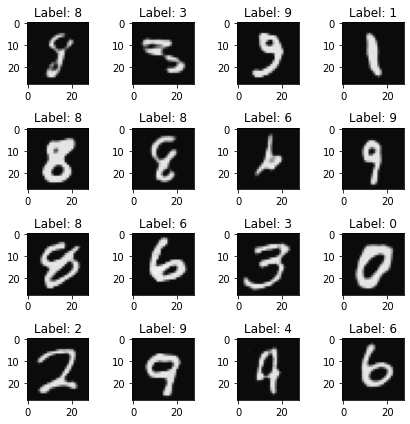

In [13]:
visualize_from_DSN(dsn,mnist_train_loader,4,'source')

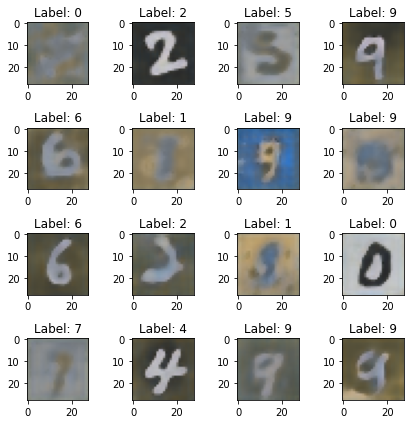

In [14]:
visualize_from_DSN(dsn,mnistm_train_loader,4,'target')
#visualize_style_from_DSN(dsn,mnist_train_loader,mnistm_train_loader,4)

In [15]:
with torch.no_grad():
    source_acc, target_acc, domain_acc,rec_loss,classify_loss,diff_loss,sim_loss = DSNAccuracy(dsn, mnist_test_loader, mnistm_test_loader)
    print(f'source_acc: {source_acc},target_acc: {target_acc}, domain_acc: {domain_acc},rec_loss: {rec_loss}')

source_acc: 0.9766,target_acc: 0.9365, domain_acc: 0.5619,rec_loss: 6.023162007331848e-05


In [210]:
from statistics import mean
def GridSearch():
    rec_weights = [0.1,0.3,0.6,0.8,1]
    diff_weights = [0.1,0.3,0.6,0.8,1]
    for rec_weight in rec_weights:
        for diff_weight in diff_weights:
            source_accs, target_accs, domain_accs, rec_losses, dsn = DSNTrain(mnist_train_loader,
                                                                 mnistm_train_loader,
                                                                 mnist_eval_loader,
                                                                 mnistm_eval_loader,intervals=300,rec_weight = rec_weight, diff_weight=diff_weight)
            print(f"rec_weight: {rec_weight}, diff_weight: {diff_weight}, target_accs: {mean(target_accs)}, domain_acc:{mean(domain_accs)},rec_loss: {mean(rec_losses)}")

In [211]:
GridSearch()

300/300: source_acc: 0.9690166666666666,target_acc: 0.6287833333333334, domain_acc: 0.5909583333333334,rec_loss: 0.00011927424271901448
rec_weight: 0.1, diff_weight: 0.1, target_accs: 0.6287833333333334, domain_acc:0.5909583333333334,rec_loss: 0.00011927424271901448
300/300: source_acc: 0.9699166666666666,target_acc: 0.5997666666666667, domain_acc: 0.58785,rec_loss: 0.00011908253828684489
rec_weight: 0.1, diff_weight: 0.3, target_accs: 0.5997666666666667, domain_acc:0.58785,rec_loss: 0.00011908253828684489
300/300: source_acc: 0.9697333333333333,target_acc: 0.5827666666666667, domain_acc: 0.6033,rec_loss: 0.00011694297790527343
rec_weight: 0.1, diff_weight: 0.6, target_accs: 0.5827666666666667, domain_acc:0.6033,rec_loss: 0.00011694297790527343
300/300: source_acc: 0.9661666666666666,target_acc: 0.6121333333333333, domain_acc: 0.610425,rec_loss: 0.00011580866177876791
rec_weight: 0.1, diff_weight: 0.8, target_accs: 0.6121333333333333, domain_acc:0.610425,rec_loss: 0.0001158086617787679

In [218]:
rec_weights = [0.05,0.075,0.01]
sim_weights = [0.1,0.5,1]
for rec_weight in rec_weights:
    for sim_weight in sim_weights:
        source_accs, target_accs, domain_accs, rec_losses, dsn = DSNTrain(mnist_train_loader,
                                                                 mnistm_train_loader,
                                                                 mnist_eval_loader,
                                                                 mnistm_eval_loader,intervals=300,rec_weight = rec_weight, sim_weight=sim_weight)
        print(f"rec_weight: {rec_weight}, sim_weight: {sim_weight}, target_accs: {mean(target_accs)}, domain_acc:{mean(domain_accs)},rec_loss: {mean(rec_losses)}")

rec_weight: 0.05, sim_weight: 0.1, target_accs: 0.52545, domain_acc:0.5838166666666667,rec_loss: 0.00010751407146453858
rec_weight: 0.05, sim_weight: 0.5, target_accs: 0.5583833333333333, domain_acc:0.5787333333333333,rec_loss: 0.00010754357973734538
rec_weight: 0.05, sim_weight: 1, target_accs: 0.5898666666666667, domain_acc:0.5696333333333333,rec_loss: 0.00010700028737386068
rec_weight: 0.075, sim_weight: 0.1, target_accs: 0.4706, domain_acc:0.58465,rec_loss: 0.00010387233893076579
rec_weight: 0.075, sim_weight: 0.5, target_accs: 0.5092166666666667, domain_acc:0.568125,rec_loss: 0.00010423275629679362
rec_weight: 0.075, sim_weight: 1, target_accs: 0.45458333333333334, domain_acc:0.5474583333333334,rec_loss: 0.0001055508534113566
rec_weight: 0.01, sim_weight: 0.1, target_accs: 0.45531666666666665, domain_acc:0.5716666666666667,rec_loss: 0.00012778352896372478
rec_weight: 0.01, sim_weight: 0.5, target_accs: 0.5272333333333333, domain_acc:0.5715583333333333,rec_loss: 0.00012677634557088

In [19]:
def generate_domain_datas_from_dsn(dsn, mnist_gen,mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = dsn.shared_encoder(source.to(device))
            source = source.view(-1,50*4*4).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = dsn.shared_encoder(target.to(device))
            target = target.view(-1,50*4*4).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [20]:
features, labels = generate_domain_datas_from_dsn(dsn, mnist_train_loader,mnistm_train_loader)

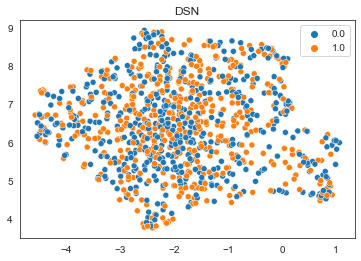

In [25]:
visualize_domain_UMAP(features, labels,name="DSN",size=1000)

In [22]:
proxy = Proxy_A_distance(np.array(features),np.array(labels),10)

In [23]:
print(proxy)

1.0909200012683868
